### Introduction and Model Setup

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from scipy.stats import norm
from google.colab import drive
import torch, os
drive.mount('/content/drive')

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


In [18]:
# Black-Scholes parameters
K = 100.0
r = 0.05
sigma = 0.25
S_range = [0.0, 3*K]
t_range = [0.0, 1.0]

In [19]:
# PINN
class PINN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=1):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        return self.model(x)

In [20]:
# Function for calculating derivatives
def derivatives(y, x, order=1):
    for _ in range(order):
        y = autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return y

In [21]:
# Loss function for the PDE
def pde_loss(model, x, t):
    inp = torch.cat([t, x], dim=1).requires_grad_(True)
    V = model(inp)

    dV_dt = derivatives(V, inp, order=1)[:, 0:1]
    dV_dS = derivatives(V, inp, order=1)[:, 1:2]
    d2V_dS2 = derivatives(dV_dS, inp, order=1)[:, 1:2]

    S = inp[:, 1:2]
    residual = dV_dt + 0.5 * sigma**2 * S**2 * d2V_dS2 + r * S * dV_dS - r * V
    return (residual**2).mean()

In [22]:
# Boundary condition loss (S=0 et S=Smax)
def boundary_loss(model, t):
    n = t.shape[0]
    S_left = torch.zeros_like(t)
    S_right = S_range[1] * torch.ones_like(t)

    # Left: Call(0, t)=0
    inp_left = torch.cat([t, S_left], dim=1)
    y_left = torch.zeros_like(t)

    # Right: Call(Smax, t)=Smax - K*exp(-r*(1-t))
    T_minus_t = 1.0 - t
    y_right = S_range[1] - K * torch.exp(-r * T_minus_t)

    inp_right = torch.cat([t, S_right], dim=1)

    loss_left = (model(inp_left) - y_left).pow(2).mean()
    loss_right = (model(inp_right) - y_right).pow(2).mean()

    return loss_left + loss_right

In [23]:
# Terminal condition loss (t=1)
def terminal_loss(model, x):
    t_terminal = torch.ones_like(x)
    inp = torch.cat([t_terminal, x], dim=1)
    payoff = torch.clamp(x - K, min=0.0)
    return (model(inp) - payoff).pow(2).mean()

In [24]:
# Data for training
n_samples = 5000
x_pde = torch.rand(n_samples, 1) * (S_range[1] - S_range[0])
t_pde = torch.rand(n_samples, 1) * (t_range[1] - t_range[0])

n_bvp = 5000
t_bvp = torch.rand(n_bvp, 1) * (t_range[1] - t_range[0])

n_evp = 5000
x_evp = torch.rand(n_evp, 1) * (S_range[1] - S_range[0])

In [25]:
# Model
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Training the PINN Model

In [ ]:
# Training
epochs = 20000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    pde = pde_loss(model, x_pde.to(device), t_pde.to(device))
    bvp = boundary_loss(model, t_bvp.to(device))
    evp = terminal_loss(model, x_evp.to(device))

    # Weighting for stabilisation
    total_loss = pde + 0.3*(bvp + evp)

    total_loss.backward()
    optimizer.step()

    loss_history.append(total_loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} | PDE: {pde.item():.4f} | BVP: {bvp.item():.4f} | EVP: {evp.item():.4f}")

Epoch 0/20000 | PDE: 0.0004 | BVP: 41064.0391 | EVP: 8921.7324
Epoch 100/20000 | PDE: 0.3601 | BVP: 36297.4492 | EVP: 7447.3262
Epoch 200/20000 | PDE: 0.6176 | BVP: 35035.4805 | EVP: 7093.6831
Epoch 300/20000 | PDE: 0.7826 | BVP: 34352.3008 | EVP: 6908.1182
Epoch 400/20000 | PDE: 0.9284 | BVP: 33784.5820 | EVP: 6755.9712
Epoch 500/20000 | PDE: 1.0954 | BVP: 33261.3516 | EVP: 6613.5088
Epoch 600/20000 | PDE: 1.5894 | BVP: 32765.8320 | EVP: 6447.3726
Epoch 700/20000 | PDE: 2.3625 | BVP: 32276.0332 | EVP: 6234.9824
Epoch 800/20000 | PDE: 2.9086 | BVP: 31789.9668 | EVP: 6085.0728
Epoch 900/20000 | PDE: 3.3806 | BVP: 31316.8203 | EVP: 5945.5454
Epoch 1000/20000 | PDE: 3.8333 | BVP: 30853.8496 | EVP: 5811.0566
Epoch 1100/20000 | PDE: 4.2351 | BVP: 30399.5215 | EVP: 5680.7798
Epoch 1200/20000 | PDE: 4.5021 | BVP: 29952.8008 | EVP: 5554.1597
Epoch 1300/20000 | PDE: 4.6005 | BVP: 29513.0020 | EVP: 5430.3872
Epoch 1400/20000 | PDE: 4.4895 | BVP: 29079.3613 | EVP: 5309.3916
Epoch 1500/20000 | PDE

In [26]:
'''
torch.save(model.state_dict(), 'model_final_1D_call.pth')
print("Model weights saved in 'model_final_1D_call.pth'")
'''

'\ntorch.save(model.state_dict(), \'model_final_1D_call.pth\')\nprint("Model weights saved in \'model_final_1D_call.pth\'")\n'

In [27]:
'''
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epochs
}, 'checkpoint_final_call.pth')
print("Complete checkpoint saved in 'checkpoint_final_call.pth'")
'''

'\ntorch.save({\n    \'model_state_dict\': model.state_dict(),\n    \'optimizer_state_dict\': optimizer.state_dict(),\n    \'epoch\': epochs\n}, \'checkpoint_final_call.pth\')\nprint("Complete checkpoint saved in \'checkpoint_final_call.pth\'")\n'

In [28]:
ckpt_path = os.path.join(
    '/content/drive/MyDrive',
    'Colab Notebooks',
    'Single asset',
    'model_final_1D_call.pth'
)

model = PINN().to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

print("Model loaded and ready for predictions")

Model loaded and ready for predictions


### Surface Analysis of Predicted Option Prices

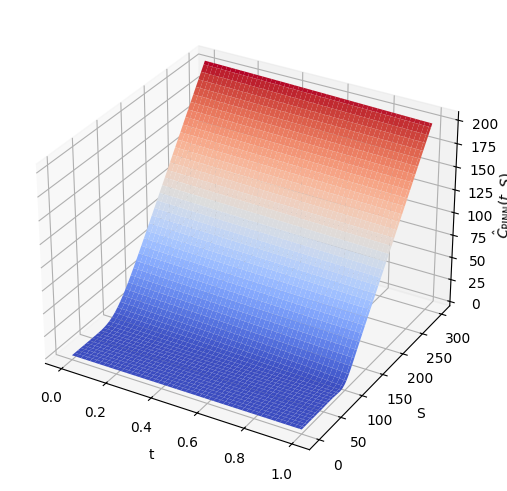

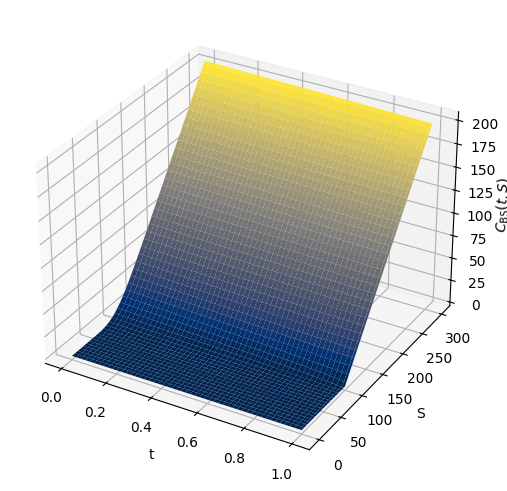

In [29]:
S_vals = np.linspace(S_range[0]+1e-2, S_range[1], 100)
t_vals = np.linspace(t_range[0], t_range[1], 100)
T_grid, S_grid = np.meshgrid(t_vals, S_vals)

def black_scholes_call(S, t, K, r, sigma):
    T_minus_t = 1.0 - t
    epsilon = 1e-10
    T_minus_t = np.maximum(T_minus_t, epsilon)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_minus_t) / (sigma * np.sqrt(T_minus_t))
    d2 = d1 - sigma * np.sqrt(T_minus_t)
    call = S * norm.cdf(d1) - K * np.exp(-r * T_minus_t) * norm.cdf(d2)
    return call

C_BS = black_scholes_call(S_grid, T_grid, K, r, sigma)

model.eval()
inputs = torch.tensor(np.column_stack([T_grid.ravel(), S_grid.ravel()]), dtype=torch.float32, device=device)
with torch.no_grad():
    C_PINN = model(inputs).cpu().numpy().reshape(S_grid.shape)

# Plot PINN
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, C_PINN, cmap='coolwarm')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\hat{C}_{\mathrm{PINN}}(t,S)$', labelpad=1)
plt.tight_layout()
plt.show()

# Plot Black-Scholes
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, C_BS, cmap='cividis')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$C_{\mathrm{BS}}(t,S)$', labelpad=1)
plt.tight_layout()
plt.show()

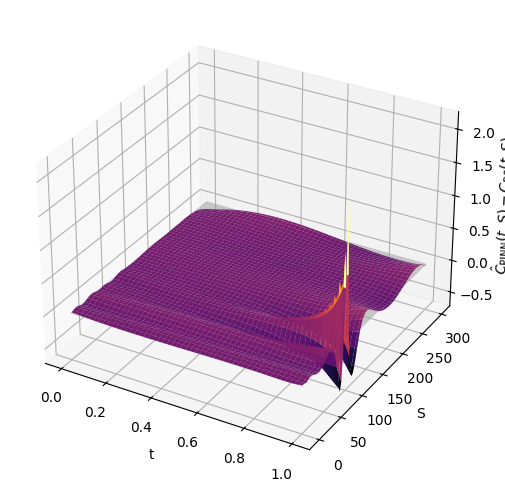

In [ ]:
# Price error calculation
error = C_PINN - C_BS

# Plot PINN
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
zero_plane = np.zeros_like(error)
ax.plot_surface(T_grid, S_grid, zero_plane, color='lightgrey', alpha=0.6)
surf = ax.plot_surface(T_grid, S_grid, error, cmap='inferno')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\hat{C}_{\mathrm{PINN}}(t,S)-C_{\mathrm{BS}}(t,S)$', labelpad=1)
plt.tight_layout()
plt.show()

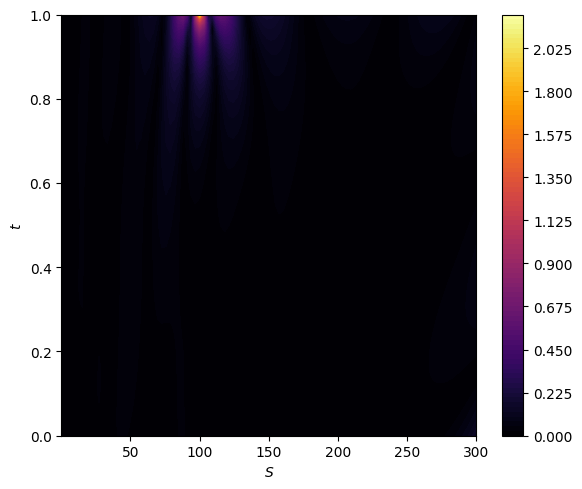

Mean Absolute Error (MAE) : 0.030419


In [ ]:
abs_error = np.abs(error)

plt.figure(figsize=(6, 5))
contour = plt.contourf(S_grid, T_grid, abs_error, levels=100, cmap='inferno')
cbar = plt.colorbar(contour)
plt.xlabel(r'$S$')
plt.ylabel(r'$t$')
plt.tight_layout()
plt.show()

# Calculation of Mean Absolute Error (MAE)
mae = np.mean(abs_error)
print(f"Mean Absolute Error (MAE) : {mae:.6f}")

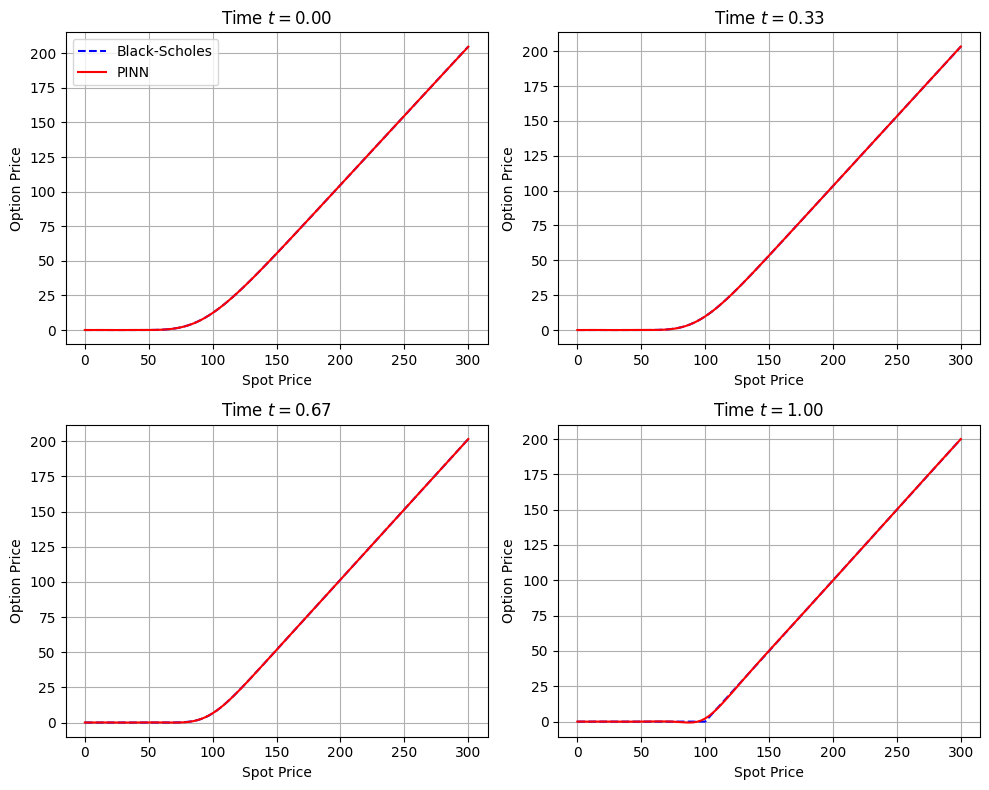

In [ ]:
# Slices
yticks = np.arange(0, 225, 25)
t_slices = [0,0.33,0.67,1]

plt.figure(figsize=(10, 8))
for i, t_val in enumerate(t_slices, 1):
    t_slice = np.full_like(S_vals, t_val)
    inputs = np.column_stack([t_slice, S_vals])

    model.eval()
    inputs_torch = torch.tensor(inputs, dtype=torch.float32, device=device)
    with torch.no_grad():
        C_PINN_slice = model(inputs_torch).cpu().numpy().flatten()
    C_BS_slice = black_scholes_call(S_vals, t_slice, K, r, sigma)

    ax = plt.subplot(2, 2, i)
    ax.plot(S_vals, C_BS_slice, 'b--', label='Black-Scholes' if i==1 else "")
    ax.plot(S_vals, C_PINN_slice, 'r-', label='PINN' if i==1 else "")

    ax.set_xlabel('Spot Price')
    ax.set_ylabel('Option Price')
    ax.set_title(rf'Time $t={t_val:.2f}$')
    ax.grid(True)
    ax.set_yticks(yticks)

    if i == 1:
        ax.legend()

plt.tight_layout()
plt.show()

### Delta Analysis

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


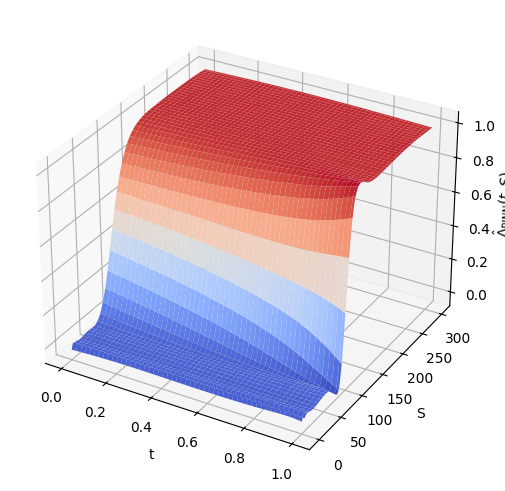

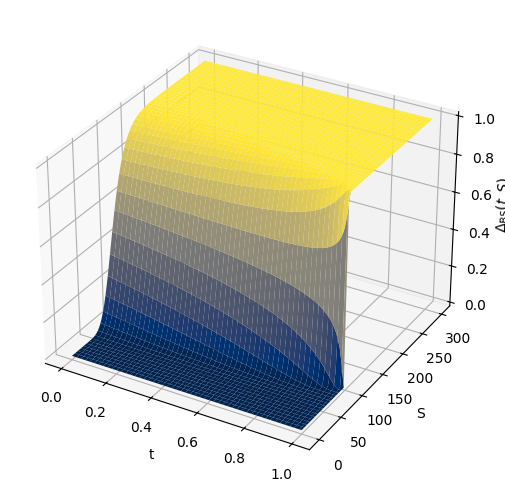

In [30]:
def delta_black_scholes(S, t, K, r, sigma):
    T_minus_t = 1.0 - t
    epsilon = 1e-10
    T_minus_t = np.maximum(T_minus_t, epsilon)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_minus_t) / (sigma * np.sqrt(T_minus_t))
    return norm.cdf(d1)

# Black-Scholes analytical delta
delta_BS = delta_black_scholes(S_grid, T_grid, K, r, sigma)

# Delta estimated by PINN
model.eval()
inputs = torch.tensor(np.column_stack([T_grid.ravel(), S_grid.ravel()]),
                       dtype=torch.float32, device=device, requires_grad=True)
V_PINN = model(inputs)

# Derivative of V with respect to S to obtain Delta
dV_dinputs = torch.autograd.grad(V_PINN, inputs,
                                 grad_outputs=torch.ones_like(V_PINN),
                                 create_graph=True, retain_graph=True)[0]
delta_PINN = dV_dinputs[:, 1].cpu().detach().numpy().reshape(S_grid.shape)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, delta_PINN, cmap='coolwarm')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\hat{\Delta}_{\mathrm{PINN}}(t,S)$', labelpad=1)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, delta_BS, cmap='cividis')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\Delta_{\mathrm{BS}}(t,S)$', labelpad=1)
plt.tight_layout()
plt.show()

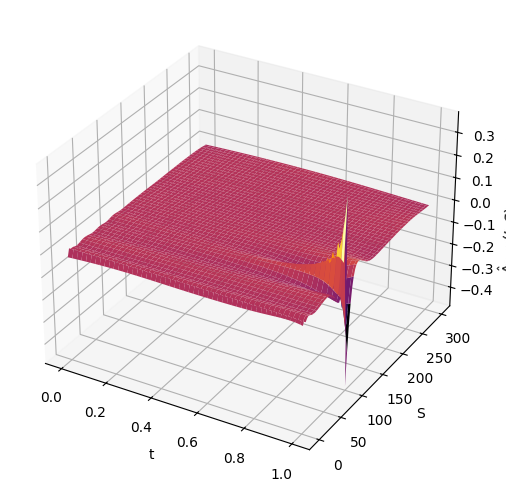

In [31]:
# Delta error calculation
error_delta = delta_PINN - delta_BS

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(T_grid, S_grid, error_delta, cmap='inferno')

ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\hat{\Delta}_{\mathrm{PINN}}(t,S)-\Delta_{\mathrm{BS}}(t,S)$', labelpad=4)
plt.tight_layout()
plt.show()

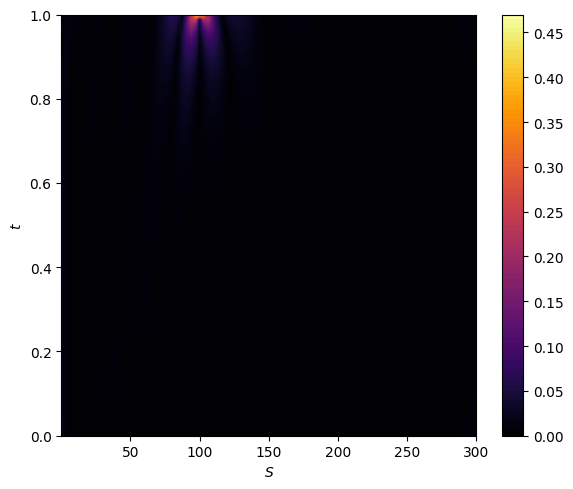

Mean Absolute Error (MAE): 0.003886


In [32]:
abs_error_delta = np.abs(delta_PINN - delta_BS)

plt.figure(figsize=(6, 5))
contour = plt.contourf(S_grid, T_grid, abs_error_delta, levels=100, cmap='inferno')
cbar = plt.colorbar(contour)
plt.xlabel(r'$S$')
plt.ylabel(r'$t$')
plt.tight_layout()
plt.show()

# Calculation of Mean Absolute Error (MAE)
mae_delta = np.mean(abs_error_delta)
print(f"Mean Absolute Error (MAE): {mae_delta:.6f}")

### Gamma Analysis

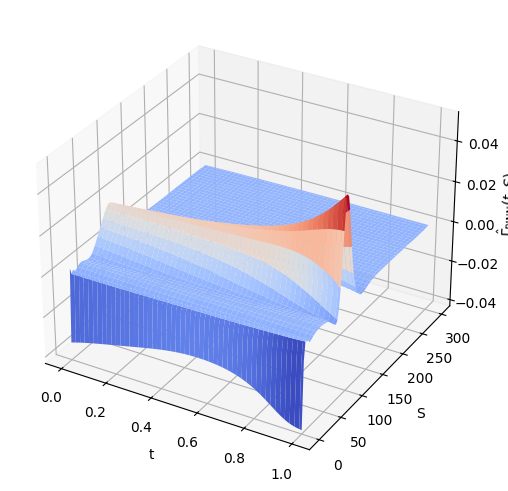

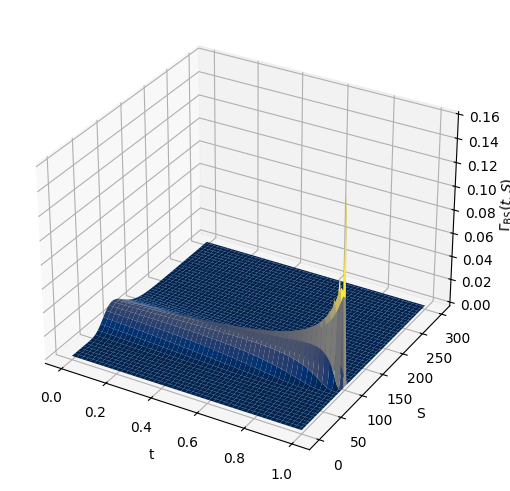

In [33]:
def gamma_black_scholes(S, t, K, r, sigma):
    T_minus_t = 1.0 - t
    epsilon = 1e-10
    T_minus_t = np.maximum(T_minus_t, epsilon)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_minus_t) / (sigma * np.sqrt(T_minus_t))
    pdf_d1 = norm.pdf(d1)
    gamma = pdf_d1 / (S * sigma * np.sqrt(T_minus_t))
    return gamma

# Black-Scholes analytical gamma
gamma_BS = gamma_black_scholes(S_grid, T_grid, K, r, sigma)

# Gamma estimated by PINN
model.eval()
inputs = torch.tensor(np.column_stack([T_grid.ravel(), S_grid.ravel()]),
                       dtype=torch.float32, device=device, requires_grad=True)

V_PINN = model(inputs)

# First derivative with respect to S
dV_dinputs = torch.autograd.grad(V_PINN, inputs,
                                 grad_outputs=torch.ones_like(V_PINN),
                                 create_graph=True, retain_graph=True)[0]

# Second derivative: derivative of dV_dS with respect to S
d2V_dS2 = torch.autograd.grad(dV_dinputs[:, 1], inputs,
                               grad_outputs=torch.ones_like(dV_dinputs[:, 1]),
                               create_graph=False, retain_graph=False)[0][:, 1]

gamma_PINN = d2V_dS2.cpu().detach().numpy().reshape(S_grid.shape)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, gamma_PINN, cmap='coolwarm')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\hat{\Gamma}_{\mathrm{PINN}}(t,S)$', labelpad=3)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, gamma_BS, cmap='cividis')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\Gamma_{\mathrm{BS}}(t,S)$', labelpad=3)
plt.tight_layout()
plt.show()

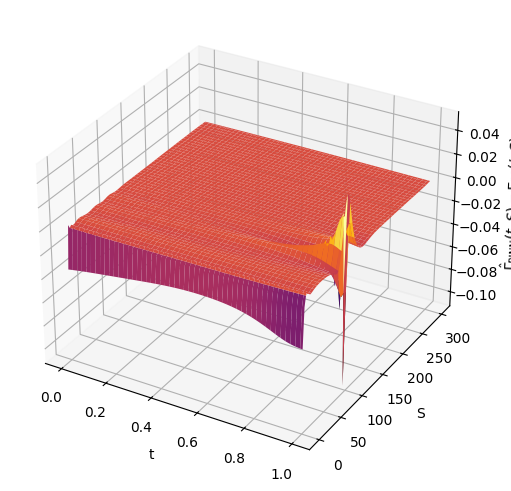

In [34]:
# Gamma error calculation
error_gamma = gamma_PINN - gamma_BS

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(T_grid, S_grid, error_gamma, cmap='inferno')

ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\hat{\Gamma}_{\mathrm{PINN}}(t,S)-\Gamma_{\mathrm{BS}}(t,S)$', labelpad=5)
plt.tight_layout()
plt.show()

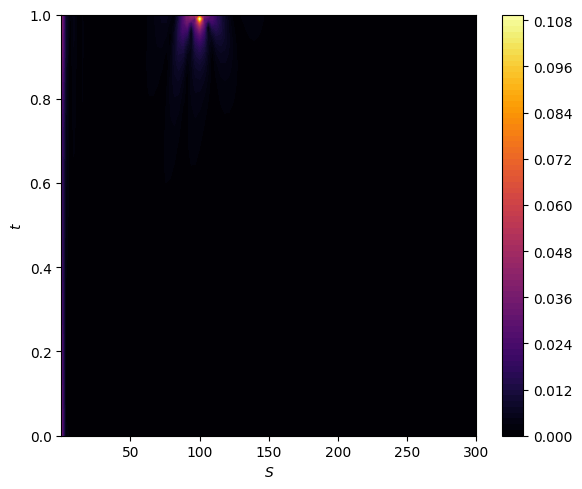

Mean Absolute Error (MAE): 0.000871


In [35]:
abs_error_gamma = np.abs(gamma_PINN - gamma_BS)

plt.figure(figsize=(6, 5))
contour = plt.contourf(S_grid, T_grid, abs_error_gamma, levels=100, cmap='inferno')
cbar = plt.colorbar(contour)
plt.xlabel(r'$S$')
plt.ylabel(r'$t$')
plt.tight_layout()
plt.show()

# Calculation of Mean Absolute Error (MAE)
mae_gamma = np.mean(abs_error_gamma)
print(f"Mean Absolute Error (MAE): {mae_gamma:.6f}")

### Theta Analysis

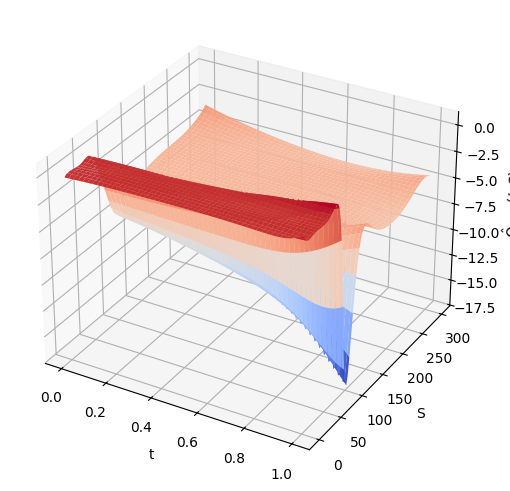

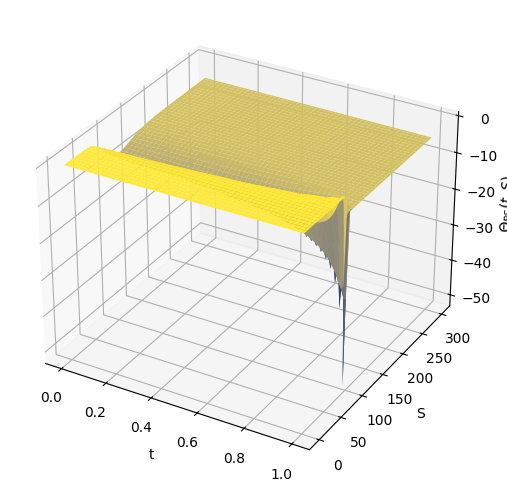

In [36]:
def theta_black_scholes(S, t, K, r, sigma, q=0.0):
    tau = 1.0 - t
    tau = np.maximum(tau, 1e-10)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    pdf_d1 = norm.pdf(d1)
    term1 = - (S * np.exp(-q * tau) * sigma * pdf_d1) / (2 * np.sqrt(tau))
    term2 =   r * K * np.exp(-r * tau) * norm.cdf(d2)
    term3 =   q * S * np.exp(-q * tau) * norm.cdf(d1)
    theta = term1 - term2 + term3
    return theta


# Black-Scholes analytical theta
theta_BS = theta_black_scholes(S_grid, T_grid, K, r, sigma)

# Theta estimated by PINN
model.eval()
inputs = torch.tensor(np.column_stack([T_grid.ravel(), S_grid.ravel()]),
                      dtype=torch.float32, device=device, requires_grad=True)

V_PINN = model(inputs)

# First derivative with respect to t
dV_dinputs = torch.autograd.grad(V_PINN, inputs,
                                 grad_outputs=torch.ones_like(V_PINN),
                                 create_graph=True, retain_graph=True)[0]
theta_PINN = dV_dinputs[:, 0].cpu().detach().numpy().reshape(S_grid.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, theta_PINN, cmap='coolwarm')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\hat{\Theta}_{\mathrm{PINN}}(t,S)$', labelpad=5)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, theta_BS, cmap='cividis')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\Theta_{\mathrm{BS}}(t,S)$', labelpad=3)
plt.tight_layout()
plt.show()

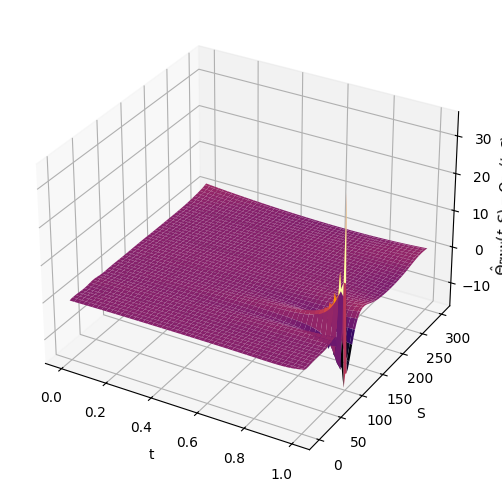

In [37]:
# Theta error calculation
error_theta = theta_PINN - theta_BS

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(T_grid, S_grid, error_theta, cmap='inferno')

ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel(r'$\hat{\Theta}_{\mathrm{PINN}}(t,S)-\Theta_{\mathrm{BS}}(t,S)$', labelpad=1)
plt.tight_layout()
plt.show()

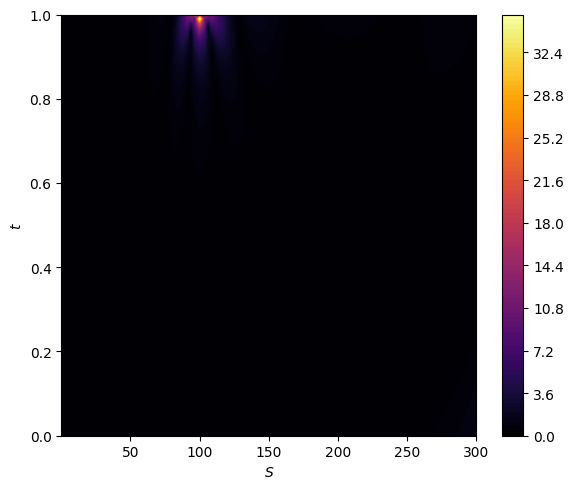

Mean Absolute Error (MAE): 0.208634


In [38]:
abs_error_theta = np.abs(theta_PINN - theta_BS)

plt.figure(figsize=(6, 5))
contour = plt.contourf(S_grid, T_grid, abs_error_theta, levels=100, cmap='inferno')
cbar = plt.colorbar(contour)
plt.xlabel(r'$S$')
plt.ylabel(r'$t$')
plt.tight_layout()
plt.show()

# Calculation of Mean Absolute Error (MAE)
mae_theta = np.mean(abs_error_theta)
print(f"Mean Absolute Error (MAE): {mae_theta:.6f}")